# Before Start
### install packages cdsapi xarray netcdf4 h5netcdf by
> !pip install cdsapi xarray netcdf4 h5netcdf

# Download data by cdsapi(skip since we already have the data)

In [ ]:
import cdsapi
c = cdsapi.Client()
print(c)

import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
import xarray as xr
import netCDF4
import h5netcdf

# bbox_korea = (20.0, 110.0, 46.0, 150.0)  # (minlat, minlon, maxlat, maxlon)
for y in ['2023','2022','2021']:
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
            ],
            'year':  y,
            'month': [f"{m:02d}" for m in range(1,13)],   # 1~12월
            'day':   [f"{d:02d}" for d in range(1,32)],   # 1~31일
            'time':  [f"{h:02d}:00" for h in range(24)],  # 00~23시
            'area':  [37.5, 127.0, 37.5, 127.0],          # 서울 좌표
            'format': 'netcdf',
        },
        f'era5_seoul_wind_{y}.nc'
    )

    # ds = xr.open_dataset('era5_seoul_wind_20202023.nc')


ModuleNotFoundError: No module named 'cdsapi'

In [3]:
# 단일 시간으로 squeeze (dims: latitude, longitude)
u = ds['u10'].squeeze()   # (lat, lon)
v = ds['v10'].squeeze()
lats = ds['latitude'].values   # 90..-90 (내림차순)
lons = ds['longitude'].values  # -180..180 또는 0..360

# 격자 생성
lon2d, lat2d = np.meshgrid(lons, lats)

# 라디안 변환
lam = np.deg2rad(lon2d)  # 경도 λ
phi = np.deg2rad(lat2d)  # 위도 φ

# S² 점 p(λ,φ)
x = np.cos(phi) * np.cos(lam)
y = np.cos(phi) * np.sin(lam)
z = np.sin(phi)
P = np.stack([x, y, z], axis=-1)  # (..., 3)

# 구면 접공간의 동/북 단위기저
e_lam = np.stack([-np.sin(lam),  np.cos(lam),  np.zeros_like(lam)], axis=-1)
e_phi = np.stack([-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam), np.cos(phi)], axis=-1)

# 탄젠트 벡터장 U_tan (m/s)
U_tan = u.values[..., None] * e_lam + v.values[..., None] * e_phi   # shape: (lat, lon, 3)

# 스칼라 풍속(크기, m/s) & 풍향(동쪽=0, 북쪽=+π/2)
speed = np.sqrt(u.values**2 + v.values**2)
azimuth = np.arctan2(v.values, u.values)  # [-π, π]

print(P.shape, U_tan.shape, speed.min(), speed.max())


(1, 1, 3) (1, 8784, 3) 0.0157868 8.970099


In [1]:
!pip install xarray netcdf4 h5netcdf

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 19.5 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 7.0/7.0 MB 54.0 MB/s  0:00:00

   ---------------------------------------- 0/5 [h5netcdf]
   ---------------------------------------- 0/5 [h5netcdf]
   ---------------- ----------------------- 2/5 [certifi]
   ------------------------ --------------- 3/5 [netcdf4]
   ------------------------ --------------- 3/5 [netcdf4]
   ------------------------ --------------- 3/5 [netcdf4]
   ------------------------ --------------- 3/5 [netcdf4]
   ------------------------ --------------- 3/5 [netcdf4]
   ------------------------ --------------- 3/5 [netcdf4]
   ------------------------ --------------- 3/5 [netcdf4]
   -------------------------------- ------- 4/5 [xarray]
   -------------------------------- ------- 4/5 [xarray]
   --------------

In [2]:
# import cdsapi
# c = cdsapi.Client()
# print(c)

import numpy as np
from datetime import datetime, timedelta, timezone
import xarray as xr
import netCDF4
import h5netcdf


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from fractions import Fraction
from math import gcd

# --- π 배수 라벨 formatter (LaTeX 스타일) ---
def pi_formatter_tex(x, pos):
    frac = Fraction(x/np.pi).limit_denominator(12)
    n, d = frac.numerator, frac.denominator
    if n == 0:
        return r"$0$"
    sign = "-" if n < 0 else ""
    n = abs(n)

    if d == 1:
        return rf"${sign}\pi$" if n == 1 else rf"${sign}{n}\pi$"
    else:
        return rf"${sign}\frac{{\pi}}{{{d}}}$" if n == 1 else rf"${sign}\frac{{{n}\pi}}{{{d}}}$"

def set_pi_ticks_auto(ax, target_ticks=6, denoms=(1,2,3,4,6,8,12,16,24,32,48,64,128,256)):
    xmin, xmax = ax.get_xlim()
    span = abs(xmax - xmin)
    if span <= 0:
        return

    candidates = [np.pi/d for d in denoms]  # 간격 후보들: π, π/2, π/3, ...
    # tick 개수가 target_ticks 근처가 되도록 base 선택
    def score(base):
        nt = span / base
        # tick이 너무 적으면 큰 페널티(“사라짐” 방지)
        penalty = 1000 if nt < 2 else 0
        return abs(nt - target_ticks) + penalty

    base = min(candidates, key=score)

    ax.xaxis.set_major_locator(mticker.MultipleLocator(base))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(pi_formatter_tex))

def make_pi_formatter_from_base(base):
    # base ≈ π/q 라고 보고 q 추정
    q = int(round(np.pi / base))
    if q <= 0:
        q = 1

    def _fmt(x, pos):
        # x ≈ k * base 이므로 k를 추정 (부동소수 오차 보정)
        k = int(round(x / base))

        if k == 0:
            return r"$0$"

        sign = "-" if k < 0 else ""
        k = abs(k)

        # kπ/q를 기약분수로
        g = gcd(k, q)
        n = k // g
        d = q // g

        if d == 1:
            return rf"${sign}\pi$" if n == 1 else rf"${sign}{n}\pi$"
        else:
            if n == 1:
                return rf"${sign}\frac{{\pi}}{{{d}}}$"
            return rf"${sign}\frac{{{n}\pi}}{{{d}}}$"

    return mticker.FuncFormatter(_fmt)

def set_pi_ticks_auto(ax, target_ticks=6, denoms=(1,2,3,4,6,8,12,16,24,32,48,64,96,128,256,512)):
    xmin, xmax = ax.get_xlim()
    span = abs(xmax - xmin)
    if span <= 0:
        return

    # 후보 간격: π/d
    bases = [np.pi/d for d in denoms]

    # tick이 너무 적어지는 걸 강하게 페널티
    def score(b):
        nt = span / b
        penalty = 1e6 if nt < 2 else 0
        return abs(nt - target_ticks) + penalty

    base = min(bases, key=score)

    ax.xaxis.set_major_locator(mticker.MultipleLocator(base))
    ax.xaxis.set_major_formatter(make_pi_formatter_from_base(base))


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
import os

# 현재 파일(script.py)의 절대 경로를 구합니다.
current_path = os.path.dirname(os.getcwd())

# 부모 디렉토리(my_project)의 경로를 구합니다.
parent_path = os.path.dirname(current_path)

# sys.path에 부모 디렉토리 경로를 추가합니다.
sys.path.append(parent_path)

In [5]:
import geomstats.backend as gs
import geomstats.errors as error
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian

from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.poincare_half_space import PoincareHalfSpace
from geomstats.geometry.spd_matrices import (
    SPDMatrices,
    SPDAffineMetric,
    SPDLogEuclideanMetric,
    SPDBuresWassersteinMetric
)
from geomstats.geometry.special_euclidean import SpecialEuclidean
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian
import geomstats.visualization as visualization
from geomstats.visualization import Sphere

import riemannian_robust_m_estimator as rrm

# Load dataset(in ./data folder)

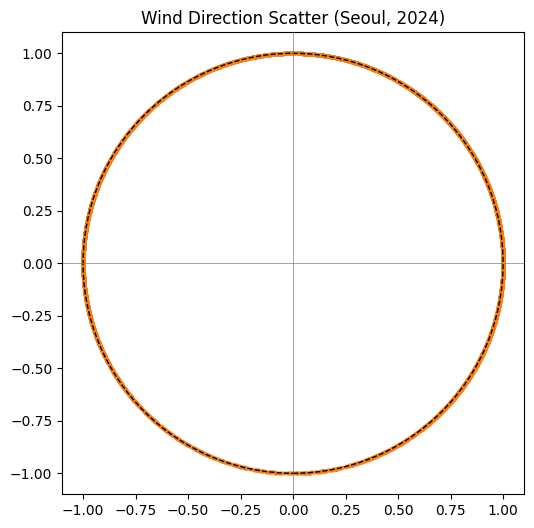

In [6]:
# 1. 데이터 확보
# u = ds["u10"].values  # shape: (time,)
# v = ds["v10"].values
# timei = np.array(ds['valid_time'])

ds = {}
for y in [2020,2021,2022,2023,2024,2025]:
    ds[y] = xr.open_dataset(f'data/era5_seoul_wind_{y}.nc')
    if y==2020:
        u = ds[y]['u10'].values
        v = ds[y]['v10'].values
        timei = np.array(ds[y]['valid_time'])
    else:
        u = np.vstack((u,ds[y]['u10'].values))
        v = np.vstack((v,ds[y]['v10'].values))
        timei = np.hstack((timei,np.array(ds[y]['valid_time'])))

# 2. 풍향각 (라디안)
theta = np.arctan2(v, u)   # -π ~ π

# 3. 단위 원 위 점
x = np.cos(theta)
y = np.sin(theta)

# 4. 산점도
plt.figure(figsize=(6,6))

mask1 = (timei > np.datetime64(datetime(2024,12,30) - timedelta(days=180))) & (timei <= np.datetime64(datetime(2024,12,30) - timedelta(days=90)))
plt.scatter(x[mask1], y[mask1], s=3, alpha=0.5)
mask2 = (timei > np.datetime64(datetime(2024,12,30) - timedelta(days=90)))
plt.scatter(x[mask2], y[mask2], s=3, alpha=0.5)
circle = plt.Circle((0,0), 1, color="black", fill=False, linestyle="--")
plt.gca().add_artist(circle)
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.gca().set_aspect("equal")
plt.title("Wind Direction Scatter (Seoul, 2024)")
plt.show()

# Trial : Computing sample means(Fre'chet mean, M-estimator)

In [7]:
circle = Hypersphere(1)
d1 = np.vstack((x.flatten(),y.flatten())).T 
circle.belongs(d1)


array([ True,  True, False, ...,  True,  True,  True])

In [8]:
fm = FrechetMean(circle)
fm.fit(X=d1)

CircleMean(space=<geomstats.geometry.hypersphere.Hypersphere object at 0x0000017E2BD86700>)

In [9]:
mest = rrm.RiemannianRobustMestimator(
    space=circle,
    m_estimator='huber',
    init_point_method='mean-projection',
    method='default',
    critical_value=0.3)
mest.set(init_step_size=1)
mest.fit(d1)

RiemannianRobustMestimator(critical_value=0.3,
                           init_point_method='mean-projection',
                           m_estimator='huber',
                           space=<geomstats.geometry.hypersphere.Hypersphere object at 0x0000017E2BD86700>)

2160 2160 2160 2159


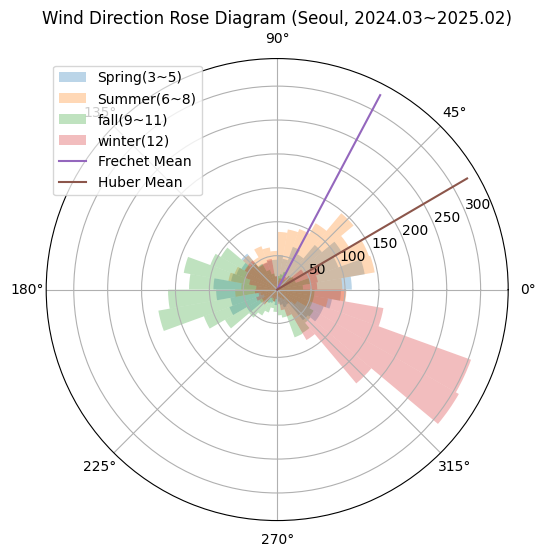

In [10]:
plt.figure(figsize=(6,6))
theta_ = theta.flatten()

plt.subplot(projection="polar")
yy = 2024
mask1 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=300))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=210)))
plt.hist(theta_[mask1],bins=36,alpha=0.3,label='Spring(3~5)')
mask2 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=210))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=120)))
plt.hist(theta_[mask2],bins=36,alpha=0.3,label='Summer(6~8)')
mask3 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=120))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=30)))
plt.hist(theta_[mask3],bins=36,alpha=0.3,label='fall(9~11)')
mask4 = (timei > np.datetime64(datetime(yy+1,3,1) - timedelta(days=90))) & (timei < np.datetime64(datetime(yy+1,3,1) - timedelta(days=0)))
plt.hist(theta_[mask4],bins=36,alpha=0.3,label='winter(12)')
print(mask1.sum(),mask2.sum(),mask3.sum(),mask4.sum())

fm_rad = np.arctan(fm.estimate_[1]/fm.estimate_[0])
mest_rad = np.arctan(mest.estimate_.x[1]/mest.estimate_.x[0])
r_max = plt.ylim()[1] # 현재 반지름 최댓값 (1.0)
plt.plot([fm_rad,fm_rad],[0,r_max],label='Frechet Mean')
plt.plot([mest_rad,mest_rad],[0,r_max],label='Huber Mean')

# plt.hist(theta.flatten(), bins=36)  # 10° 구간 (360/36)
plt.title(f"Wind Direction Rose Diagram (Seoul, {yy}.03~{yy+1}.02)")
plt.legend()
plt.show()

2160 2160 2160 2159


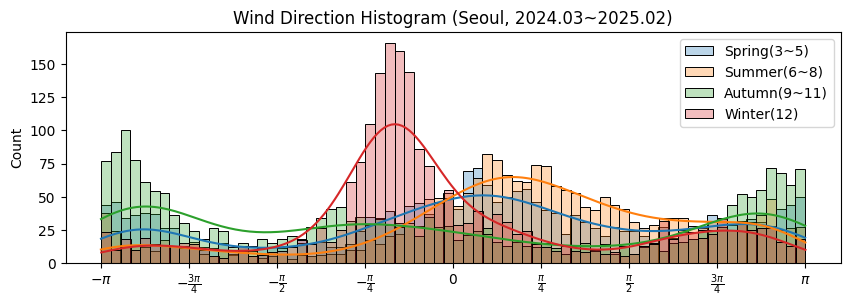

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,3))
theta_ = theta.flatten()

# plt.subplot(projection="polar")
yy = 2024
mask1 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=300))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=210)))
sns.histplot(theta_[mask1],bins=72,alpha=0.3,label='Spring(3~5)',kde=True,ax=ax)
mask2 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=210))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=120)))
sns.histplot(theta_[mask2],bins=72,alpha=0.3,label='Summer(6~8)',kde=True,ax=ax)
mask3 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=120))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=30)))
sns.histplot(theta_[mask3],bins=72,alpha=0.3,label='Autumn(9~11)',kde=True,ax=ax)
mask4 = (timei > np.datetime64(datetime(yy+1,3,1) - timedelta(days=90))) & (timei < np.datetime64(datetime(yy+1,3,1) - timedelta(days=0)))
sns.histplot(theta_[mask4],bins=72,alpha=0.3,label='Winter(12)',kde=True,ax=ax)
print(mask1.sum(),mask2.sum(),mask3.sum(),mask4.sum())

fm_rad = np.arctan(fm.estimate_[1]/fm.estimate_[0])
mest_rad = np.arctan(mest.estimate_.x[1]/mest.estimate_.x[0])
r_max = plt.ylim()[1] # 현재 반지름 최댓값 (1.0)
# ax.plot([fm_rad,fm_rad],[0,r_max],label='Frechet Mean',c='red')
# ax.plot([mest_rad,mest_rad],[0,r_max],label='Huber Mean',c='green')

set_pi_ticks_auto(ax, target_ticks=8)
# plt.hist(theta.flatten(), bins=36)  # 10° 구간 (360/36)
plt.title(f"Wind Direction Histogram (Seoul, {yy}.03~{yy+1}.02)")
plt.legend()
plt.show()

In [12]:
import logging
logging.basicConfig(level=logging.ERROR)  #WARNING
logging.getLogger('root').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Smeariness simulation by bootstrapping for sample means by 2024 winter(2024.12~2025.02) wind field data.

In [16]:
yy = 2024
mask1 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=300))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=210)))
mask2 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=210))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=120)))
mask3 = (timei > np.datetime64(datetime(yy,12,30) - timedelta(days=120))) & (timei <= np.datetime64(datetime(yy,12,30) - timedelta(days=30)))
mask4 = (timei > np.datetime64(datetime(yy+1,3,1) - timedelta(days=90))) & (timei < np.datetime64(datetime(yy+1,3,1) - timedelta(days=0)))
# sns.histplot(theta_[mask3],bins=72,alpha=0.3,label='Fall(9~11)',kde=True,ax=ax)
tgt = d1[mask4]  #[:,0],d1[mask3][:,1]
n = tgt.shape[0]


n_bootstrap = 100
n_means = 100
mean_theta_c_base = np.repeat(0.0,n_bootstrap*n_means).reshape(n_bootstrap,n_means)
mean_theta_c_mest = np.repeat(0.0,n_bootstrap*n_means).reshape(n_bootstrap,n_means)
mean_theta_c_mest_b = np.repeat(0.0,n_bootstrap*n_means).reshape(n_bootstrap,n_means)
t_thetas = [-np.pi/7,np.pi,6*np.pi/7]
t_starts = np.vstack((np.cos(t_thetas),np.sin(t_thetas))).T
np.random.seed(1000)
for b in range(n_bootstrap):

    for i_m in range(n_means):
        sample_ix = np.random.choice(list(range(n)),n,replace=True)
        t1 = tgt[sample_ix]

        fm = FrechetMean(circle)
        fm.fit(X=t1)
        fm_1 = fm.estimate_
        fm_1_rad = np.arctan2(fm_1[1],fm_1[0])
        mean_theta_c_base[b,i_m] = fm_1_rad

        mest_ = {}
        mest_loss_ix = []
        for t,t_s in enumerate(t_starts):  #np.random.choice(list(range(n)),3,replace=False)
            mest_[t] = rrm.RiemannianRobustMestimator(
                space=circle,
                m_estimator='huber',
                init_point_method='mean-projection',
                method='default',
                critical_value=np.pi/4)
            mest_[t].set(max_iter=4096,init_step_size=0.1,init_point=t_s)  #t1[ix]
            mest_[t].fit(t1)
            mest_loss_ix.append(mest_[t].estimate_.losses[-1])
        min_ix = np.argsort(mest_loss_ix)[0]
        mest_res = mest_[min_ix].estimate_.x
        mest_rad = np.arctan2(mest_res[1],mest_res[0])
        mean_theta_c_mest[b,i_m] = mest_rad
        #print('huber done')
        mest_b = {}
        mest_b_loss_ix = []
        for t,t_s in enumerate(t_starts): #np.random.choice(list(range(n)),3,replace=False)
            mest_b[t] = rrm.RiemannianRobustMestimator(
                space=circle,
                m_estimator='biweight',
                init_point_method='mean-projection',
                method='adaptive',
                critical_value=np.pi/2)
            mest_b[t].set(max_iter=4096,init_step_size=1.5,init_point=t_s)
            mest_b[t].fit(t1)
            mest_b_loss_ix.append(mest_b[t].estimate_.losses[-1])
        min_ix = np.argsort(mest_b_loss_ix)[0]
        mest_b_res = mest_b[min_ix].estimate_.x
        mest_b_rad = np.arctan2(mest_b_res[1],mest_b_res[0])
        mean_theta_c_mest_b[b,i_m] = mest_b_rad
        #print('hampel done')
    if b%10==0:
        print(b,'bootstraps complete')


KeyboardInterrupt: 

## Save the bootstrap result of 2024 winter wind direction

In [ ]:
import pickle
with open(f'winddir_smeary_simulation_{yy}_winter.pkl','wb') as f_:
    pickle.dump({
        'base':mean_theta_c_base,
        'huber_pi/4':mean_theta_c_mest,
        'biweight_pi/2':mean_theta_c_mest_b,
        },f_)

## Load the bootstrap result

In [17]:
import pickle
with open('winddir_smeary_simulation_2024_winter.pkl','rb') as f_:
    mmm = pickle.load(f_)
mean_theta_c_base = mmm['base']
mean_theta_c_mest = mmm['huber_pi/4']
mean_theta_c_mest_b = mmm['biweight_pi/2']

In [18]:
bbvar_base = []
bbvar_mest = []
bbvar_mest_b = []
for i in range(100):
    rvar = rrm.riemannian_variance(
        Hypersphere(1),
        np.vstack((np.cos(mean_theta_c_base[i]),np.sin(mean_theta_c_base[i]))).T
    )
    bbvar_base.append(rvar)
    rvar = rrm.riemannian_variance(
        Hypersphere(1),
        np.vstack((np.cos(mean_theta_c_mest[i]),np.sin(mean_theta_c_mest[i]))).T
    )
    bbvar_mest.append(rvar)
    rvar = rrm.riemannian_variance(
        Hypersphere(1),
        np.vstack((np.cos(mean_theta_c_mest_b[i]),np.sin(mean_theta_c_mest_b[i]))).T
    )
    bbvar_mest_b.append(rvar)

## Plot smeariness chart of sample means(Frechet, Huber) and biweight mean.

-0.46392416236557554


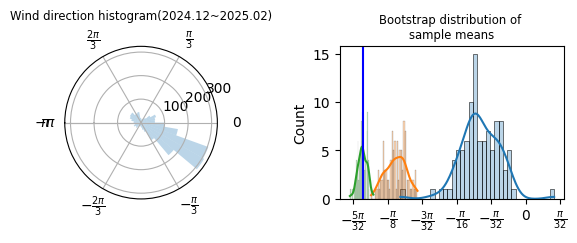

In [20]:
fig = plt.figure(figsize=(6,2.5))

ax = plt.subplot(121,projection="polar")
ax.set_thetalim(-np.pi, np.pi)
theta_tgt = np.arctan2(tgt[:,1],tgt[:,0])
ax.hist(theta_tgt,bins=36,alpha=0.3,label='base')
ax.set_title('Wind direction histogram(2024.12~2025.02)',fontsize='small')
set_pi_ticks_auto(ax, target_ticks=6)
# ax = plt.subplot(132)
# sns.histplot(bbvar_base,bins=36,alpha=0.3,kde=True,label='Frechet mean',ax=ax)
# sns.histplot(bbvar_mest,bins=36,alpha=0.3,kde=True,label='Huber mean',ax=ax)
# sns.histplot(bbvar_mest_b,bins=36,alpha=0.3,kde=True,label='Biweight mean',ax=ax)
# ax.set_title('Bootstrap distribution of \nvariances of sample means',fontsize='small')
# set_pi_ticks_auto(ax, target_ticks=6)

ax = plt.subplot(122) # ,projection="polar")
ix = 60
sns.histplot(mean_theta_c_base[ix],bins=36,alpha=0.3,kde=True,label='Frechet mean',ax=ax)
sns.histplot(mean_theta_c_mest[ix],bins=36,alpha=0.3,kde=True,label='Huber mean',ax=ax)
sns.histplot(mean_theta_c_mest_b[ix],bins=36,alpha=0.3,kde=True,label='Biweight mean',ax=ax)
base_rad = np.mean(mean_theta_c_mest_b[:100,:])
print(base_rad)
plt.axvline(x=base_rad,c='blue',label='True mean')

ax.set_title('Bootstrap distribution of \nsample means',fontsize='small')
#ax[0].legend(fontsize='x-small')
#ax[1].legend()
set_pi_ticks_auto(ax, target_ticks=6)
#plt.tight_layout()
fig.subplots_adjust(wspace=0.6)
plt.tight_layout()
os.makedirs('../plots_realdata',exist_ok=True)
plt.savefig('../plots_realdata/wind_circle_smeary.png')
plt.savefig('../plots_realdata/wind_circle_smeary.pdf')
plt.savefig('../plots_realdata/wind_circle_smeary.eps')

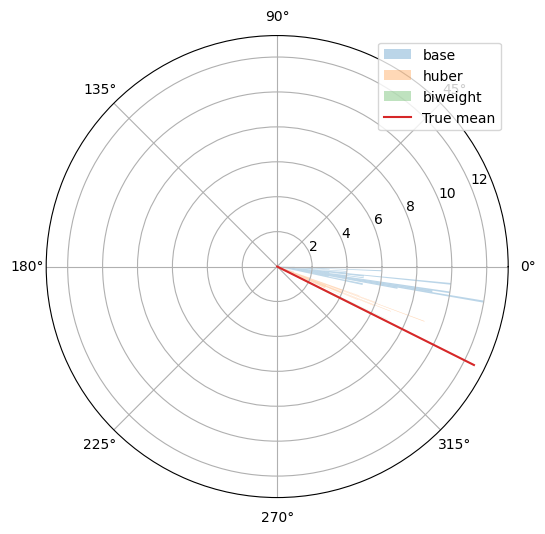

In [23]:
plt.figure(figsize=(6,6))
plt.subplot(projection="polar")
ix = 100
plt.hist(mean_theta_c_base[ix],bins=36,alpha=0.3,label='base')
plt.hist(mean_theta_c_mest[ix],bins=36,alpha=0.3,label='huber')
plt.hist(mean_theta_c_mest_b[ix],bins=36,alpha=0.3,label='biweight')

# base_rad = np.arctan2(base[1],base[0])
r_max = plt.ylim()[1] # 현재 반지름 최댓값 (1.0)
plt.plot([base_rad,base_rad],[0,r_max],label='True mean')

plt.legend()

## Realdata analysis : seasonal, non-gaussian underlying distribution assumption, 
## pairwise distance method, Cutoff = 0.7 $\sqrt{tr(\Sigma)}$

In [ ]:
theta_ = theta.flatten()
fig,ax = plt.subplots(1,4,figsize=(14,4),subplot_kw={'projection':'polar'})
# plt.subplot(projection="polar")

tss = pd.Series(timei)
for i,yy in enumerate(ds.keys()):
    if yy==2025: continue
    for i,(season,mm) in enumerate([('Spring',[3,4,5]),('Summer',[6,7,8]),('Autumn',[9,10,11]),('Winter',[12,1,2]),]):
        if season == 'winter':
            mask = ((tss.dt.year == yy) & (tss.dt.month.isin([12])) )|((tss.dt.year == yy+1) & (tss.dt.month.isin([1,2])))
        else:
            mask = (tss.dt.year == yy) & (tss.dt.month.isin(mm))
        ax[i].hist(theta_[mask],bins=36,alpha=0.3,label=str(int(yy)))
        ax[i].set_title(f'{season}({",".join([str(k) for k in mm])})')

        d_season = d1[mask]

        pd1 = circle.metric.dist_pairwise(d_season)
        rx, cx = np.triu_indices(pd1.shape[0])
        upper_pd1 = pd1[rx, cx]**2

        # d_eff = 2*E^2 / V
        mean_obs, var_obs = np.mean(upper_pd1),np.var(upper_pd1,ddof=1)
        d_eff_est = (2 * mean_obs**2) / var_obs
        # sigma^2 = E / (2 * d_eff)
        sigma_sq_est = mean_obs / (2 * d_eff_est)
        cutoff_ = 0.7*np.sqrt(sigma_sq_est)
        print(yy,season,cutoff_)

        fm = FrechetMean(circle)
        fm.fit(X=d_season)
        
        mest_ = {}
        mest_loss_ix = []
        for t,ix in enumerate(np.random.choice(list(range(len(d_season))),3,replace=False)):
            mest_[t] = rrm.RiemannianRobustMestimator(
                space=circle,
                m_estimator='biweight',
                init_point_method='mean-projection',
                method='default',
                critical_value=cutoff_)
            mest_[t].set(max_iter=4096,init_step_size=3,init_point=d_season[ix])
            mest_[t].fit(d_season)
            mest_loss_ix.append(mest_[t].estimate_.losses[-1])
        min_ix = np.argsort(mest_loss_ix)[0]
        mest_res = mest_[min_ix].estimate_.x
        
        fm_rad = np.arctan2(fm.estimate_[1],fm.estimate_[0])
        mest_rad = np.arctan2(mest_res[1],mest_res[0])

        r_max = ax[i].get_ylim()[1] # 현재 반지름 최댓값 (1.0)
        ax[i].plot([fm_rad,fm_rad],[0,r_max],label='Fréchet Mean' if yy==2024 else None,c='red',linewidth=1.5)
        ax[i].text(fm_rad,r_max,str(int(yy)),c='red',fontsize=7.5)
        ax[i].plot([mest_rad,mest_rad],[0,r_max],label='Biweight Mean' if yy==2024 else None,c='green',linewidth=1.5)
        ax[i].text(mest_rad,r_max,str(int(yy)),c='green',fontsize=7.5)
        
# ax[0].hist(theta_, bins=36)  # 10° 구간 (360/36)
# plt.title("Wind Direction Rose Diagram (Seoul, 2020~2024)")
ax[3].legend(loc='upper left',fontsize='small',bbox_to_anchor=(1.01,1))
# fig.suptitle("Wind Direction Rose Diagram (Seoul, 2020~2024)")
plt.tight_layout()

plt.savefig('../plots_realdata/wind_circle_seasonal_non_gaussian_biweight.png')
plt.savefig('../plots_realdata/wind_circle_seasonal_non_gaussian_biweight.pdf')
plt.savefig('../plots_realdata/wind_circle_seasonal_non_gaussian_biweight.eps')

plt.show()


2020 Spring 0.6036937227888459
2020 Summer 0.5930237056810914
2020 Autumn 0.5851981716416366
2020 Winter 0.611803005791122
2021 Spring 0.5891970769459831


## Realdata analysis : monthly, non-gaussian underlying distribution assumption, 
## pairwise distance method, Cutoff = 0.7 $\sqrt{tr(\Sigma)}$

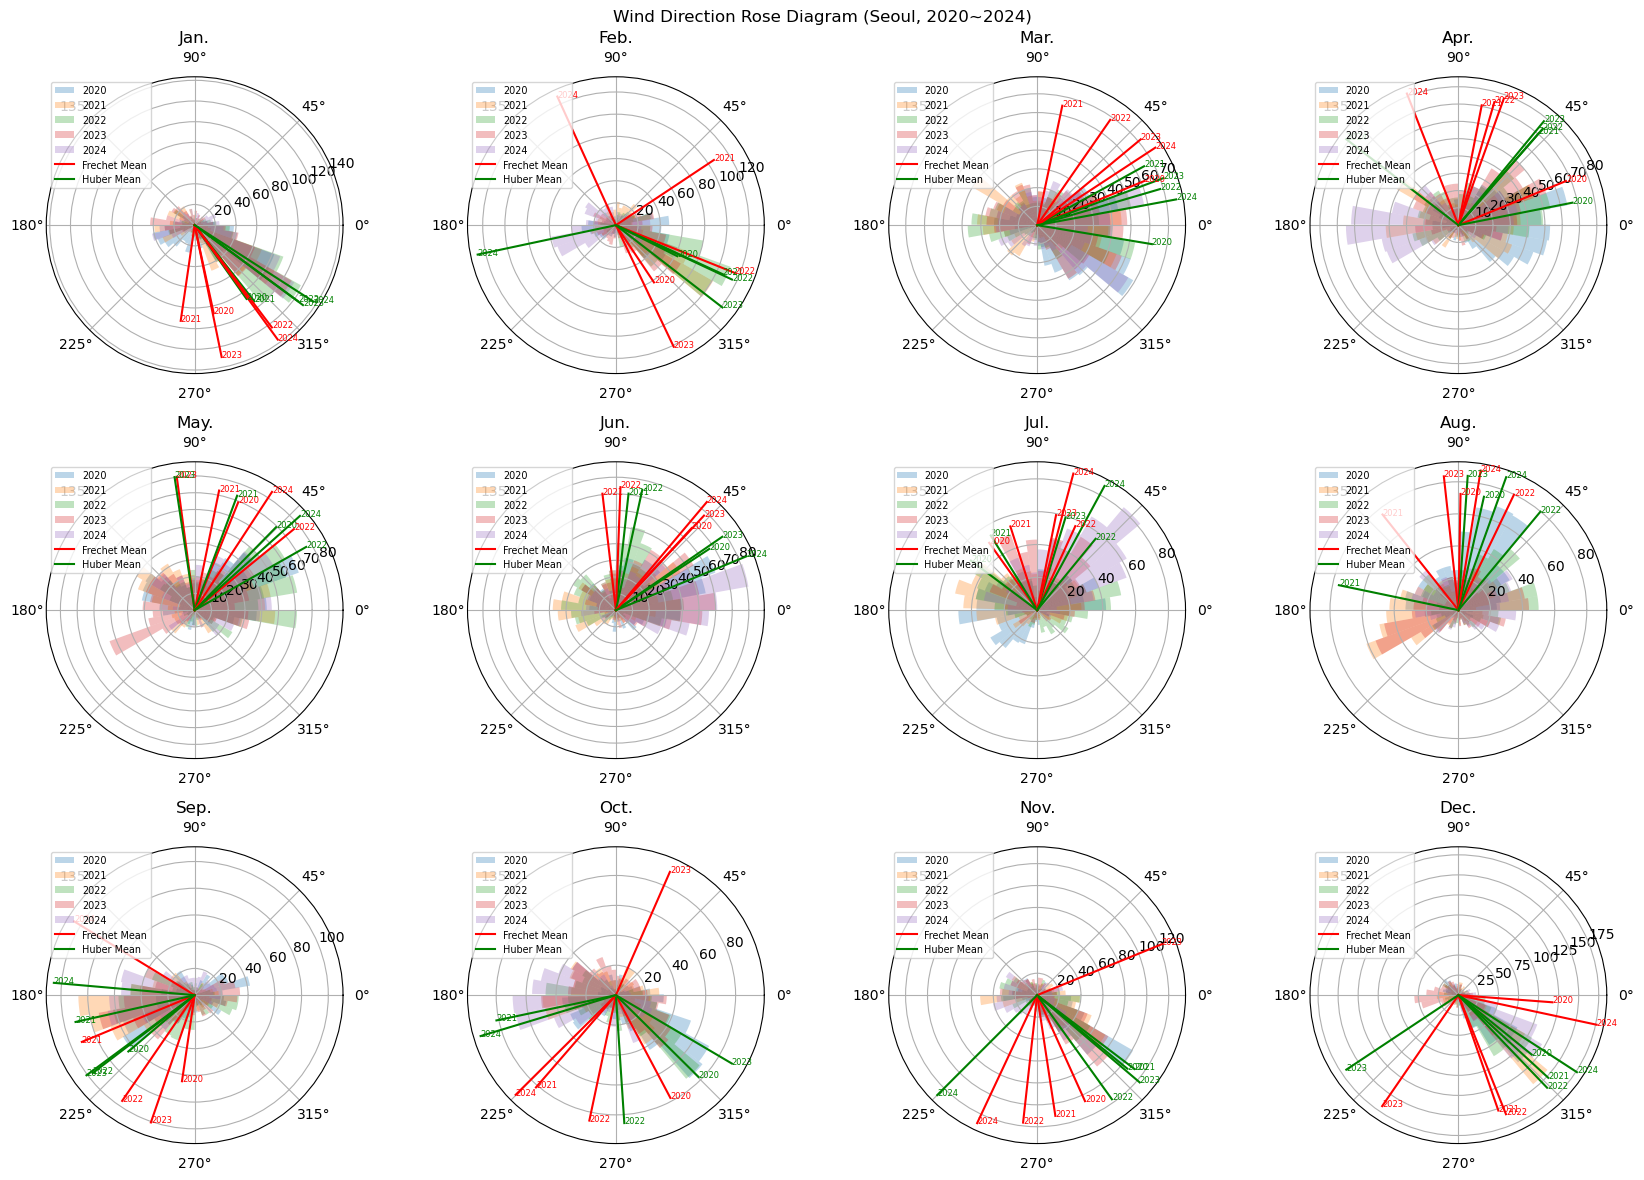

In [ ]:
theta_ = theta.flatten()
fig,ax = plt.subplots(3,4,figsize=(17,12),subplot_kw={'projection':'polar'})
# plt.subplot(projection="polar")

tss = pd.Series(timei)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for j in range(1,13):
    for i,yy in enumerate(ds.keys()):
        axc = ((j-1)//4,(j-1)%4)
        month = (tss.dt.year == yy) & (tss.dt.month==j)
        ax[axc].hist(theta_[month],bins=36,alpha=0.3,label=str(int(yy)))
        
        d_month = d1[month]
        fm = FrechetMean(circle)
        fm.fit(X=d_month)
        
        pd1 = circle.metric.dist_pairwise(d_month)
        rx, cx = np.triu_indices(pd1.shape[0])
        upper_pd1 = pd1[rx, cx]**2

        # Q1 & Q2 해답: 유효 차원 및 Isotropic 파라미터 역산
        # 공식: d_eff = 2*E^2 / V
        mean_obs, var_obs = np.mean(upper_pd1),np.var(upper_pd1,ddof=1)
        d_eff_est = (2 * mean_obs**2) / var_obs
        # 공식: sigma^2 = E / (2 * d_eff)
        sigma_sq_est = mean_obs / (2 * d_eff_est)
        #rho_sq_est = (var_obs/4)/mean_obs
        cutoff_ = 0.7*np.sqrt(sigma_sq_est)
        print(yy,season,cutoff_)

        mest_ = {}
        mest_loss_ix = []
        for t,ix in enumerate(np.random.choice(list(range(len(d_month))),5,replace=False)):
            mest_[t] = rrm.RiemannianRobustMestimator(
                space=circle,
                m_estimator='huber',
                init_point_method='mean-projection',
                method='default',
                critical_value=cutoff_)
            mest_[t].set(max_iter=4096,init_step_size=0.3,init_point=d_month[ix])
            mest_[t].fit(d_month)
            mest_loss_ix.append(mest_[t].estimate_.losses[-1])
        min_ix = np.argsort(mest_loss_ix)[0]
        mest_res = mest_[min_ix].estimate_.x
        
        fm_rad = np.arctan2(fm.estimate_[1],fm.estimate_[0])
        mest_rad = np.arctan2(mest_res[1],mest_res[0])
        r_max = ax[axc].get_ylim()[1] # 현재 반지름 최댓값 (1.0)
        ax[axc].plot([fm_rad,fm_rad],[0,r_max],label='Frechet Mean' if yy==2024 else None,c='red',linewidth=1.5)
        ax[axc].text(fm_rad,r_max,str(int(yy)),c='red',fontsize=6)
        ax[axc].plot([mest_rad,mest_rad],[0,r_max],label='Huber Mean' if yy==2024 else None,c='green',linewidth=1.5)
        ax[axc].text(mest_rad,r_max,str(int(yy)),c='green',fontsize=6)

    ax[axc].set_title(f'{months[j-1]}.')
    ax[axc].legend(loc='upper left',fontsize='x-small')
    
# ax[0].hist(theta_, bins=36)  # 10° 구간 (360/36)
plt.suptitle("Wind Direction Rose Diagram (Seoul, 2020~2024)")

plt.tight_layout()

plt.savefig('../plots_realdata/wind_circle_monthly_non_gaussian.png')
plt.savefig('../plots_realdata/wind_circle_monthly_non_gaussian.pdf')
plt.savefig('../plots_realdata/wind_circle_monthly_non_gaussian.eps')

plt.show()

## Realdata analysis : seasonal, Gaussian underlying distribution assumption, 
## pairwise distance method, Cutoff = 1.386 $\sqrt{tr(\Sigma)}$

In [ ]:
theta_ = theta.flatten()
fig,ax = plt.subplots(1,4,figsize=(14,4),subplot_kw={'projection':'polar'})
# plt.subplot(projection="polar")

tss = pd.Series(timei)
for i,yy in enumerate(ds.keys()):
    if yy==2025: continue
    for i,(season,mm) in enumerate([('Spring',[3,4,5]),('Summer',[6,7,8]),('Autumn',[9,10,11]),('Winter',[12,1,2]),]):
        if season == 'winter':
            mask = ((tss.dt.year == yy) & (tss.dt.month.isin([12])) )|((tss.dt.year == yy+1) & (tss.dt.month.isin([1,2])))
        else:
            mask = (tss.dt.year == yy) & (tss.dt.month.isin(mm))
        ax[i].hist(theta_[mask],bins=36,alpha=0.3,label=str(int(yy)))
        ax[i].set_title(f'{season}({",".join([str(k) for k in mm])})')

        d_season = d1[mask]

        pd1 = circle.metric.dist_pairwise(d_season)
        rx, cx = np.triu_indices(pd1.shape[0])
        upper_pd1 = pd1[rx, cx]**2

        # Q1 & Q2 해답: 유효 차원 및 Isotropic 파라미터 역산
        # 공식: d_eff = 2*E^2 / V
        mean_obs, var_obs = np.mean(upper_pd1),np.var(upper_pd1,ddof=1)
        d_eff_est = (2 * mean_obs**2) / var_obs
        # 공식: sigma^2 = E / (2 * d_eff)
        sigma_sq_est = mean_obs / (2 * d_eff_est)
        #rho_sq_est = (var_obs/4)/mean_obs
        #cutoff_ = 0.75*np.sqrt(sigma_sq_est)
        cutoff_ = 1.386*np.sqrt(sigma_sq_est)
        print(yy,season,cutoff_)

        fm = FrechetMean(circle)
        fm.fit(X=d_season)
        
        mest_ = {}
        mest_loss_ix = []
        for t,ix in enumerate(np.random.choice(list(range(len(d_season))),3,replace=False)):
            mest_[t] = rrm.RiemannianRobustMestimator(
                space=circle,
                m_estimator='huber',
                init_point_method='mean-projection',
                method='default',
                critical_value=cutoff_)
            mest_[t].set(max_iter=4096,init_step_size=0.3,init_point=d_season[ix])
            mest_[t].fit(d_season)
            mest_loss_ix.append(mest_[t].estimate_.losses[-1])
        min_ix = np.argsort(mest_loss_ix)[0]
        mest_res = mest_[min_ix].estimate_.x
        
        fm_rad = np.arctan2(fm.estimate_[1],fm.estimate_[0])
        mest_rad = np.arctan2(mest_res[1],mest_res[0])

        r_max = ax[i].get_ylim()[1] # 현재 반지름 최댓값 (1.0)
        ax[i].plot([fm_rad,fm_rad],[0,r_max],label='Fréchet Mean' if yy==2024 else None,c='red',linewidth=1.5)
        ax[i].text(fm_rad,r_max,str(int(yy)),c='red',fontsize=7.5)
        ax[i].plot([mest_rad,mest_rad],[0,r_max],label='Huber Mean' if yy==2024 else None,c='green',linewidth=1.5)
        ax[i].text(mest_rad,r_max,str(int(yy)),c='green',fontsize=7.5)
        
# ax[0].hist(theta_, bins=36)  # 10° 구간 (360/36)
# plt.title("Wind Direction Rose Diagram (Seoul, 2020~2024)")
ax[3].legend(loc='upper left',fontsize='small',bbox_to_anchor=(1.01,1))
# fig.suptitle("Wind Direction Rose Diagram (Seoul, 2020~2024)")
plt.tight_layout()

plt.savefig('../plots_realdata/wind_circle_seasonal_yes_gaussian.png')
plt.savefig('../plots_realdata/wind_circle_seasonal_yes_gaussian.pdf')
plt.savefig('../plots_realdata/wind_circle_seasonal_yes_gaussian.eps')

plt.show()
